# Importing Libraries

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn
from sklearn import neighbors
from sklearn import metrics
import seaborn as sns
from matplotlib.colors import ListedColormap
import pickle

# Importing files

In [4]:
training = "master.csv"
training1 = "lec_tues_4.csv"
training2 = "lab_wed_4.csv"
training3 = "tut_wed_4.csv"
training4 = "lab_fri_4.csv"
training5 = "tut_fri_4.csv"
training6 = "sun_4.csv"
training7 = "lab_wed_5.csv"

path = "C:\\Users\\ieliz\\Documents\\2021\\FYP\\Stress_Detection_FYP\\python_scripts\\"

In [5]:
os.chdir(path)
print(os.getcwd())
df = pd.read_csv(training)
df1 = pd.read_csv(training1)
df2 = pd.read_csv(training2)
df3 = pd.read_csv(training3)
df4 = pd.read_csv(training4)
df5 = pd.read_csv(training5)
df6 = pd.read_csv(training6)
df7 = pd.read_csv(training7)

df = df.append(df1, ignore_index=True)
df = df.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
df = df.append(df4, ignore_index=True)
df = df.append(df5, ignore_index=True)
df = df.append(df6, ignore_index=True)
df = df.append(df7, ignore_index=True)

df["Time (hr:min:sec)"] = pd.to_datetime(df["Time (hr:min:sec)"], format="%H:%M:%S").dt.time

C:\Users\ieliz\Documents\2021\FYP\Stress_Detection_FYP\python_scripts


In [6]:
# TESTING DATA
test = "lab_wed_4.csv"
test1 = "lab_mon_5.csv"

df_test = pd.read_csv(test)
df_test1 = pd.read_csv(test1)

df_test = df_test.append(df_test1, ignore_index=True)

df_test["Time (hr:min:sec)"] = pd.to_datetime(df_test["Time (hr:min:sec)"], format="%H:%M:%S").dt.time

In [7]:
df

,Time (hr:min:sec),Time (s),GSR,Resistance,Conductance (uS),Heart_Rate,Section,Stressed
0,12:00:01,1,225,51358.88502,19.470828,68,RelaxM4_,2
1,12:00:02,2,224,51111.11111,19.565217,68,RelaxM4_,2
2,12:00:03,3,224,51111.11111,19.565217,69,RelaxM4_,2
3,12:00:04,4,225,51358.88502,19.470828,68,RelaxM4_,2
4,12:00:05,5,224,51111.11111,19.565217,68,RelaxM4_,2
...,...,...,...,...,...,...,...,...
59691,11:31:49,3597,439,260547.94520,3.838065,63,wed_lab_5_3,2
59692,11:31:50,3598,439,260547.94520,3.838065,63,wed_lab_5_3,2
59693,11:31:51,3599,443,276811.59420,3.612565,63,wed_lab_5_3,2
59694,11:31:52,3600,444,281176.47060,3.556485,63,wed_lab_5_3,2


In [8]:
df["Section"].unique()

array(['RelaxM4_', 'LabM4_1_', 'LabM4_2_', 'LabM4_3_', 'lec_tues_0',
       'lab_wed_4_0', 'lab_wed_4_1', 'lab_wed_4_2', 'tut_wed_4_0',
       'tut_wed_4_1', 'lab_fri4_1', 'tut_fri4_1', 'tut_fri4_2',
       'sun_data_1', 'sun_data', 'wed_lab_5_1', 'wed_lab_5_2',
       'wed_lab_5_3'], dtype=object)

# Calculating Conductance

In [9]:
# df["Conductance (uS)"] = 1*10**6/df["Resistance"]

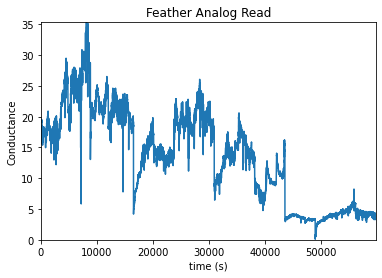

In [10]:
fig, ax = plt.subplots()
ax.set_xlim((0, len(df)))
ax.set_ylim((0, max(df["Conductance (uS)"])))
ax.set_title('Feather Analog Read')
ax.set_xlabel("time (s)")
ax.set_ylabel("Conductance")
ax.plot(df.index, df["Conductance (uS)"])

# Pre-processing Data and Feature Extraction
## Separating into sections

In [11]:
df["Section_labels"] = df["Section"] + df["Stressed"].astype(str)
unique_sections = df["Section_labels"].unique()
unique_sections_num = df["Section_labels"].nunique()
print(unique_sections)

labels = []
for name in unique_sections:
    curr_label = df.loc[df["Section_labels"] == name, 'Stressed'].unique()[0]
    labels.append(curr_label)
    
print(labels)

['RelaxM4_2' 'LabM4_1_6' 'LabM4_1_4' 'LabM4_2_7' 'LabM4_3_6' 'LabM4_3_4'
 'lec_tues_04' 'lab_wed_4_04' 'lab_wed_4_05' 'lab_wed_4_14' 'lab_wed_4_15'
 'lab_wed_4_13' 'lab_wed_4_22' 'lab_wed_4_23' 'tut_wed_4_02'
 'tut_wed_4_05' 'tut_wed_4_12' 'tut_wed_4_14' 'lab_fri4_14' 'lab_fri4_17'
 'lab_fri4_13' 'lab_fri4_15' 'tut_fri4_14' 'tut_fri4_13' 'tut_fri4_15'
 'tut_fri4_23' 'tut_fri4_24' 'tut_fri4_25' 'tut_fri4_27' 'sun_data_14'
 'sun_data_15' 'sun_data_13' 'sun_data_16' 'sun_data_12' 'sun_data2'
 'sun_data4' 'sun_data3' 'wed_lab_5_14' 'wed_lab_5_15' 'wed_lab_5_13'
 'wed_lab_5_16' 'wed_lab_5_24' 'wed_lab_5_25' 'wed_lab_5_27'
 'wed_lab_5_23' 'wed_lab_5_34' 'wed_lab_5_35' 'wed_lab_5_33'
 'wed_lab_5_36' 'wed_lab_5_32']
[2, 6, 4, 7, 6, 4, 4, 4, 5, 4, 5, 3, 2, 3, 2, 5, 2, 4, 4, 7, 3, 5, 4, 3, 5, 3, 4, 5, 7, 4, 5, 3, 6, 2, 2, 4, 3, 4, 5, 3, 6, 4, 5, 7, 3, 4, 5, 3, 6, 2]


## Moving average filter

In [12]:
def moving_ave_filter(df):
    df["Conductance (uS)"] = df["Conductance (uS)"].rolling(2).mean()  #1 second moving average filter
    df["Heart_Rate"] = df["Heart_Rate"].rolling(2).mean()  #1 second moving average filter
    df = df.dropna()
    return df

In [13]:
df = df.groupby(df["Section_labels"]).apply(moving_ave_filter)    

In [14]:
df

Time (hr:min:sec)  Time (s)  GSR    Resistance  \
Section_labels                                                        
LabM4_1_4      1501           13:05:02      1502  238   54744.52555   
               1502           13:05:03      1503  238   54744.52555   
               1503           13:05:04      1504  238   54744.52555   
               1504           13:05:05      1505  238   54744.52555   
               1505           13:05:06      1506  237   54472.72727   
...                                ...       ...  ...           ...   
wed_lab_5_36   59347          11:26:02      3253  435  245974.02600   
               59348          11:26:03      3254  436  249473.68420   
               59349          11:26:04      3255  440  264444.44440   
               59350          11:26:05      3256  439  260547.94520   
               59351          11:26:06      3257  439  260547.94520   

                      Conductance (uS)  Heart_Rate      Section  Stressed  \
Section_labels                                                              
LabM4_1_4      1501          18.312239        78.0     LabM4_1_         4   
               1502          18.266667        78.0     LabM4_1_         4   
               1503          18.266667        78.0     LabM4_1_         4   
               1504          18.266667        78.0     LabM4_1_         4   
               1505          18.312239        80.5     LabM4_1_         4   
...                                ...         ...          ...       ...   
wed_lab_5_36   59347          4.122682        80.5  wed_lab_5_3         6   
               59348          4.036954        80.5  wed_lab_5_3         6   
               59349          3.894976        81.0  wed_lab_5_3         6   
               59350          3.809789        81.0  wed_lab_5_3         6   
               59351          3.838065        81.0  wed_lab_5_3         6   

                     Section_labels  
Section_labels                       
LabM4_1_4      1501       LabM4_1_4  
               1502       LabM4_1_4  
               1503       LabM4_1_4  
               1504       LabM4_1_4  
               1505       LabM4_1_4  
...                             ...  
wed_lab_5_36   59347   wed_lab_5_36  
               59348   wed_lab_5_36  
               59349   wed_lab_5_36  
               59350   wed_lab_5_36  
               59351   wed_lab_5_36  

[59646 rows x 9 columns]

## Min-Max Normalisation

In [15]:
def min_max_normalisation(df):
    min_val_gsr = min(df['Conductance (uS)'])
    max_val_gsr = max(df['Conductance (uS)'])
    scaling_gsr = max_val_gsr-min_val_gsr
    df.loc[:, 'Normalised_GSR'] = (df.loc[:, 'Conductance (uS)']- min_val_gsr)/scaling_gsr 
    
    min_val_hr = min(df["Heart_Rate"])
    max_val_hr = max(df["Heart_Rate"])
    scaling_hr = max_val_hr-min_val_hr
    df.loc[:, "Normalised_HR"] = (df.loc[:, "Heart_Rate"]- min_val_hr)/scaling_hr 
    return df

In [16]:
df = df.groupby(df["Section_labels"]).apply(min_max_normalisation)

In [17]:
df

Time (hr:min:sec)  Time (s)  GSR    Resistance  \
Section_labels                                                        
LabM4_1_4      1501           13:05:02      1502  238   54744.52555   
               1502           13:05:03      1503  238   54744.52555   
               1503           13:05:04      1504  238   54744.52555   
               1504           13:05:05      1505  238   54744.52555   
               1505           13:05:06      1506  237   54472.72727   
...                                ...       ...  ...           ...   
wed_lab_5_36   59347          11:26:02      3253  435  245974.02600   
               59348          11:26:03      3254  436  249473.68420   
               59349          11:26:04      3255  440  264444.44440   
               59350          11:26:05      3256  439  260547.94520   
               59351          11:26:06      3257  439  260547.94520   

                      Conductance (uS)  Heart_Rate      Section  Stressed  \
Section_labels                                                              
LabM4_1_4      1501          18.312239        78.0     LabM4_1_         4   
               1502          18.266667        78.0     LabM4_1_         4   
               1503          18.266667        78.0     LabM4_1_         4   
               1504          18.266667        78.0     LabM4_1_         4   
               1505          18.312239        80.5     LabM4_1_         4   
...                                ...         ...          ...       ...   
wed_lab_5_36   59347          4.122682        80.5  wed_lab_5_3         6   
               59348          4.036954        80.5  wed_lab_5_3         6   
               59349          3.894976        81.0  wed_lab_5_3         6   
               59350          3.809789        81.0  wed_lab_5_3         6   
               59351          3.838065        81.0  wed_lab_5_3         6   

                     Section_labels  Normalised_GSR  Normalised_HR  
Section_labels                                                      
LabM4_1_4      1501       LabM4_1_4        0.525135       0.355556  
               1502       LabM4_1_4        0.519731       0.355556  
               1503       LabM4_1_4        0.519731       0.355556  
               1504       LabM4_1_4        0.519731       0.355556  
               1505       LabM4_1_4        0.525135       0.411111  
...                             ...             ...            ...  
wed_lab_5_36   59347   wed_lab_5_36        0.606612       0.386792  
               59348   wed_lab_5_36        0.523026       0.386792  
               59349   wed_lab_5_36        0.384596       0.396226  
               59350   wed_lab_5_36        0.301538       0.396226  
               59351   wed_lab_5_36        0.329107       0.396226  

[59646 rows x 11 columns]

## Extract Phasic components

## Applying low pass filter

In [18]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [19]:
def low_pass(df):
    df["LPF_GSR"] = butter_lowpass_filter(df["Normalised_GSR"], cutoff, fs, order)
    df["LPF_HR"] = butter_lowpass_filter(df["Normalised_HR"], cutoff, fs, order)
    return df

## Identifying onset and offset of stressor
## Find peaks and maximum amplitude
## Find average

In [20]:
# For each section of data
# Label as stressed/not stressed
# Find peak, maximum amplitude and average GSR
# Training data: peak, max and average GSR + label

# Filter requirements
order = 6
fs = 60      # sample rate, Hz
cutoff = 20  # desired cutoff frequency of the filter, Hz

In [21]:
# Low pass filter
df = df.groupby(df["Section_labels"]).apply(low_pass)

In [22]:
df

Time (hr:min:sec)  Time (s)  GSR    Resistance  \
Section_labels                                                        
LabM4_1_4      1501           13:05:02      1502  238   54744.52555   
               1502           13:05:03      1503  238   54744.52555   
               1503           13:05:04      1504  238   54744.52555   
               1504           13:05:05      1505  238   54744.52555   
               1505           13:05:06      1506  237   54472.72727   
...                                ...       ...  ...           ...   
wed_lab_5_36   59347          11:26:02      3253  435  245974.02600   
               59348          11:26:03      3254  436  249473.68420   
               59349          11:26:04      3255  440  264444.44440   
               59350          11:26:05      3256  439  260547.94520   
               59351          11:26:06      3257  439  260547.94520   

                      Conductance (uS)  Heart_Rate      Section  Stressed  \
Section_labels                                                              
LabM4_1_4      1501          18.312239        78.0     LabM4_1_         4   
               1502          18.266667        78.0     LabM4_1_         4   
               1503          18.266667        78.0     LabM4_1_         4   
               1504          18.266667        78.0     LabM4_1_         4   
               1505          18.312239        80.5     LabM4_1_         4   
...                                ...         ...          ...       ...   
wed_lab_5_36   59347          4.122682        80.5  wed_lab_5_3         6   
               59348          4.036954        80.5  wed_lab_5_3         6   
               59349          3.894976        81.0  wed_lab_5_3         6   
               59350          3.809789        81.0  wed_lab_5_3         6   
               59351          3.838065        81.0  wed_lab_5_3         6   

                     Section_labels  Normalised_GSR  Normalised_HR   LPF_GSR  \
Section_labels                                                                 
LabM4_1_4      1501       LabM4_1_4        0.525135       0.355556  0.061117   
               1502       LabM4_1_4        0.519731       0.355556  0.306080   
               1503       LabM4_1_4        0.519731       0.355556  0.595982   
               1504       LabM4_1_4        0.519731       0.355556  0.592868   
               1505       LabM4_1_4        0.525135       0.411111  0.454513   
...                             ...             ...            ...       ...   
wed_lab_5_36   59347   wed_lab_5_36        0.606612       0.386792  0.567255   
               59348   wed_lab_5_36        0.523026       0.386792  0.603122   
               59349   wed_lab_5_36        0.384596       0.396226  0.559299   
               59350   wed_lab_5_36        0.301538       0.396226  0.407641   
               59351   wed_lab_5_36        0.329107       0.396226  0.306098   

                        LPF_HR  
Section_labels                  
LabM4_1_4      1501   0.041381  
               1502   0.207665  
               1503   0.405661  
               1504   0.405590  
               1505   0.317953  
...                        ...  
wed_lab_5_36   59347  0.394133  
               59348  0.389424  
               59349  0.388106  
               59350  0.390616  
               59351  0.398025  

[59646 rows x 13 columns]

In [23]:
# Finding max, min and average test values
GSR_peaks = []
GSR_max_peaks = []
GSR_min_peaks = []
GSR_num_peaks = []
GSR_average = []

HR_peaks = []
HR_max_peaks = []
HR_min_peaks = []
HR_num_peaks = []
HR_average = []

0 1.004099149465926 0.011767330011636393 1.03795232951334 0.39553737463598965 0.4261168090596529 0.6379639366994915 2
1 0.9936324985185733 0.021283170761200523 1.008563810130135 0.1669871500119693 0.2948915713647863 0.45695069402676314 6
2 1.033479360389775 0.010787679139463872 1.0056447189739717 0.3347604415464518 0.3546378835576026 0.5696627213423787 4
3 1.0258883677524275 0.004621793988601749 1.0132685575311475 0.3131355980133615 0.28145457278926767 0.6236958845543807 7
4 0.9759927769175671 0.04280953895076736 1.0576308376701995 0.02855988267415835 0.3251880534082178 0.5388680756460867 6
5 1.0502285285023407 0.0026142001542687424 1.009442884248539 0.009364787542504777 0.38247711182871263 0.4208126014601307 4
6 1.0658754292718577 0.0082286876309048 1.0056865610259322 0.5380390662336714 0.39724929808838083 0.7635931388686837 4
7 0.9626621814305277 0.1444708360592353 1.000462527835053 0.013888443596215156 0.4248333970079932 0.573450690157332 4
8 1.0157511406816233 0.043411602783372305 

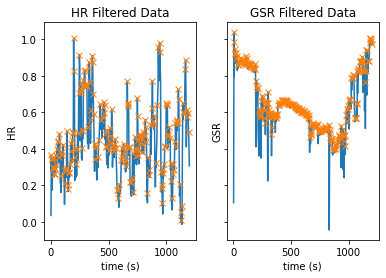

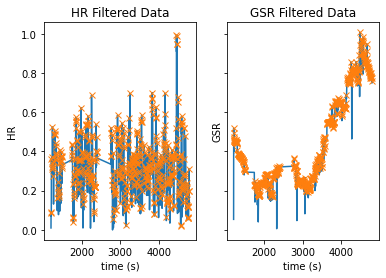

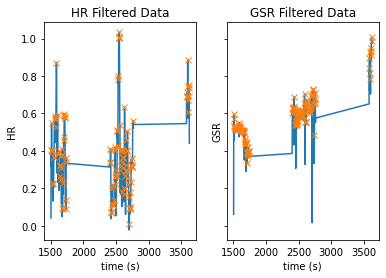

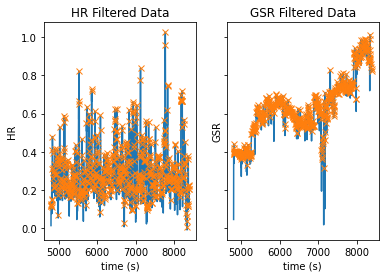

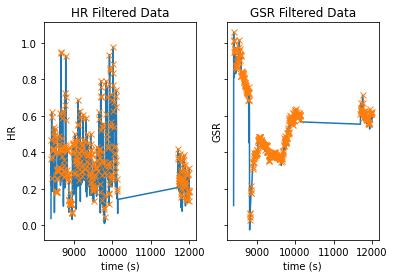

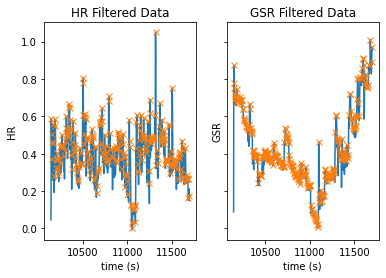

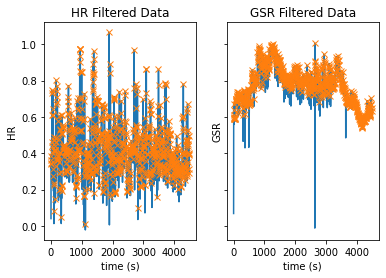

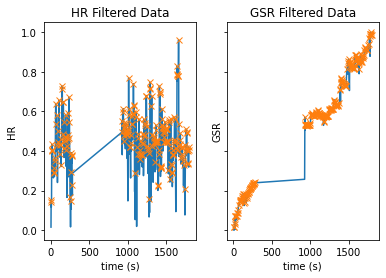

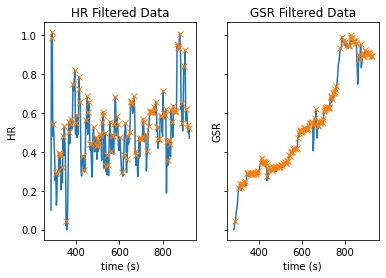

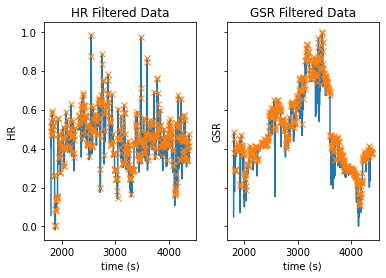

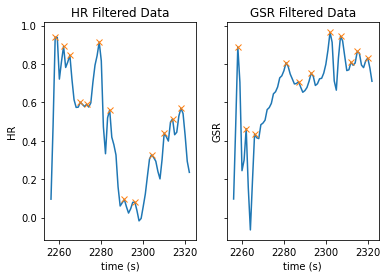

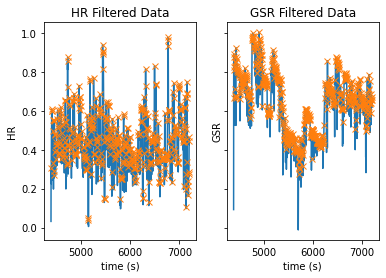

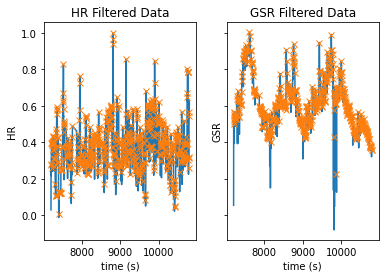

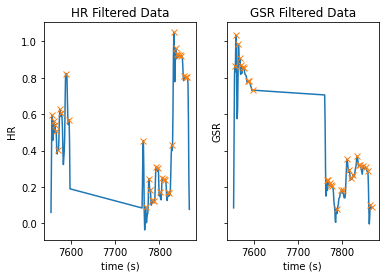

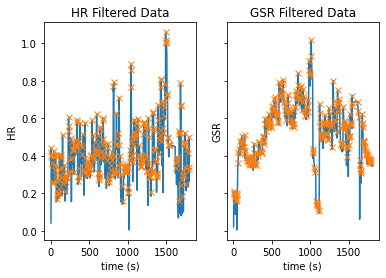

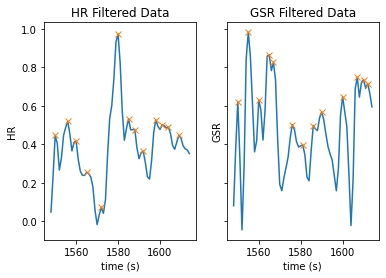

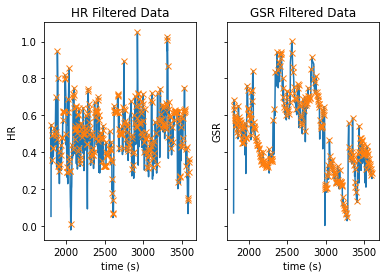

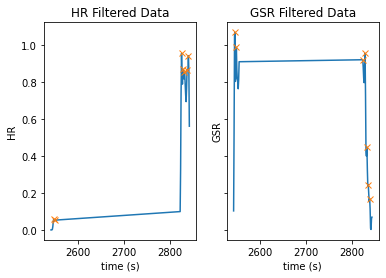

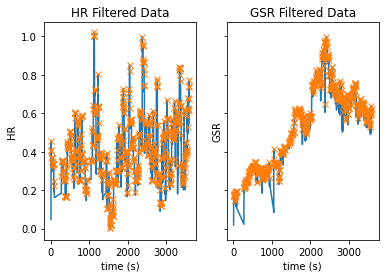

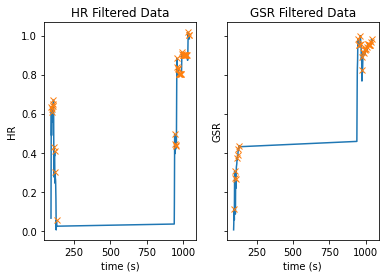

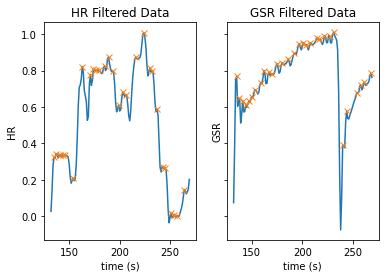

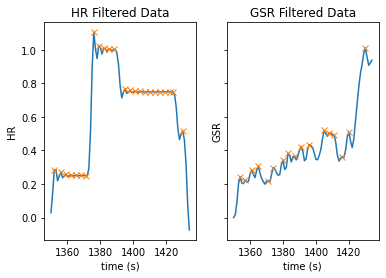

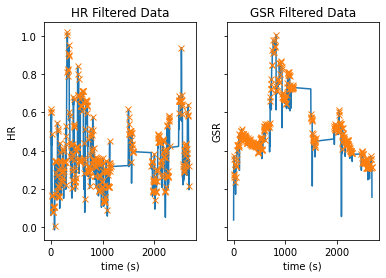

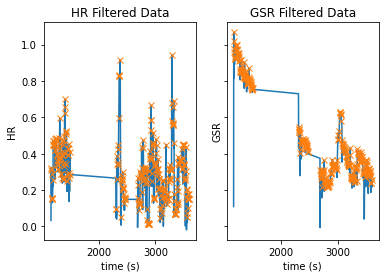

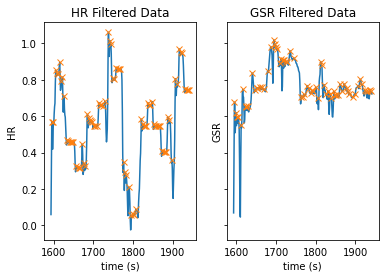

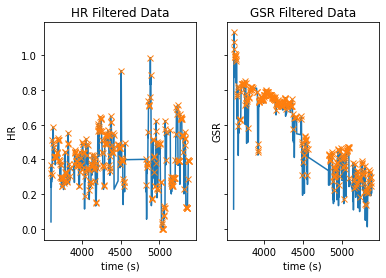

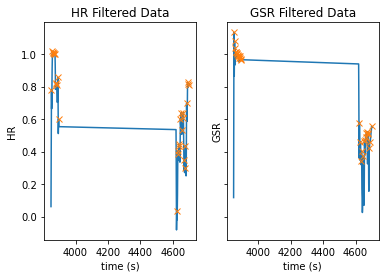

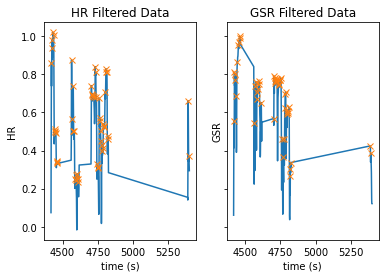

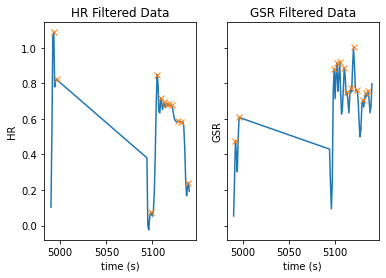

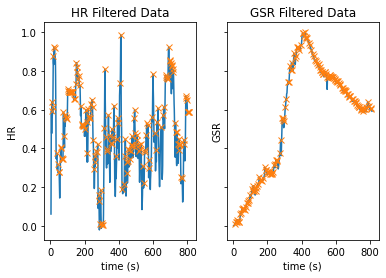

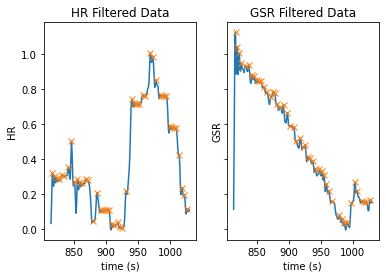

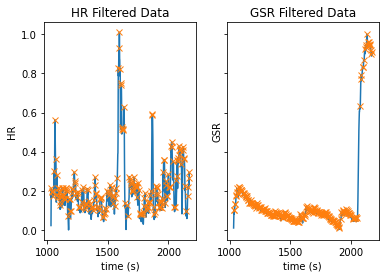

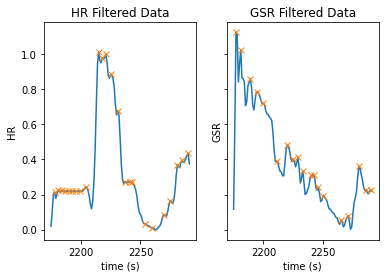

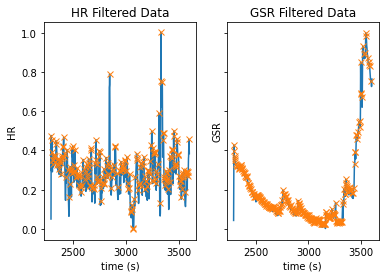

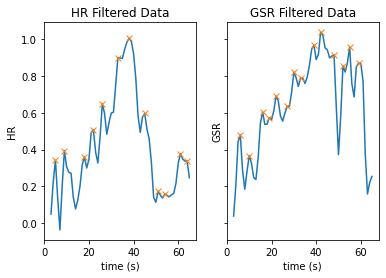

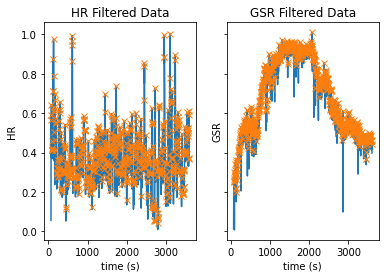

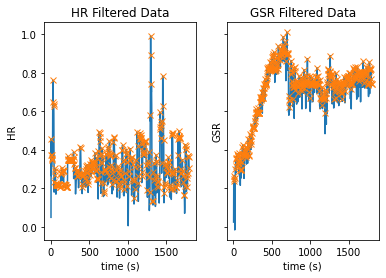

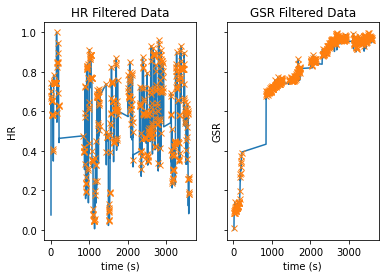

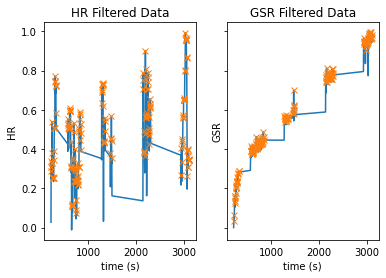

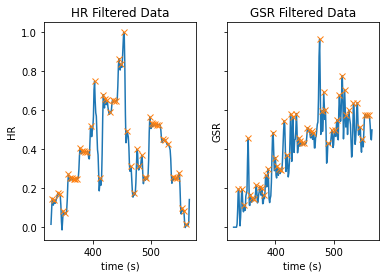

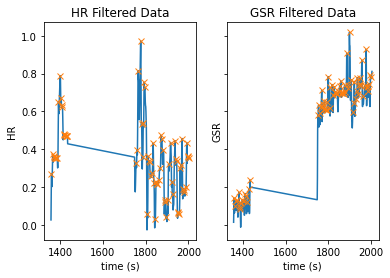

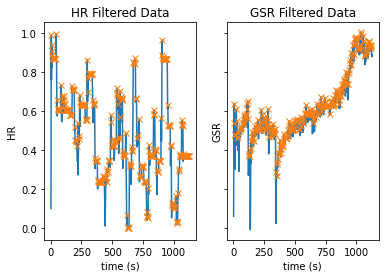

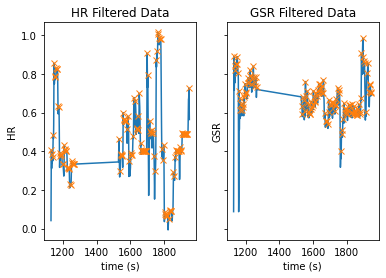

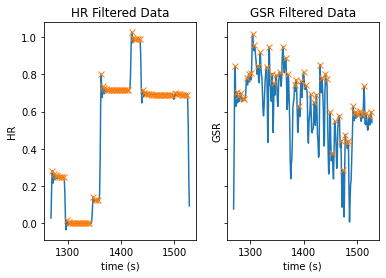

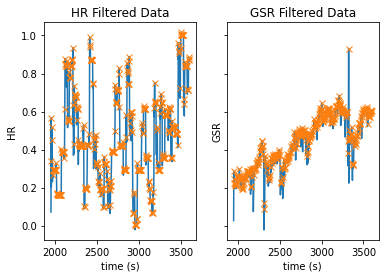

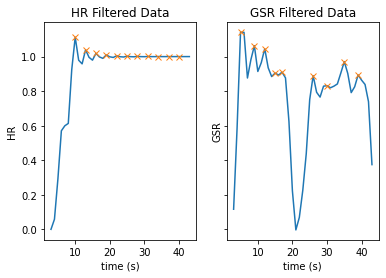

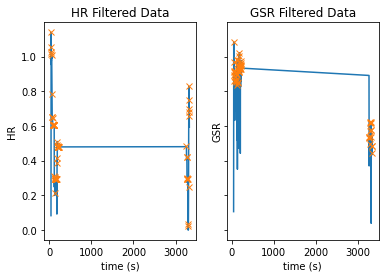

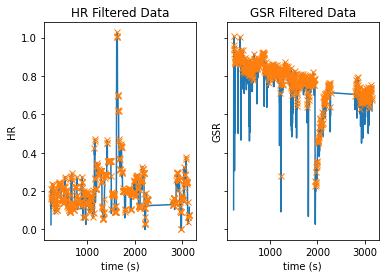

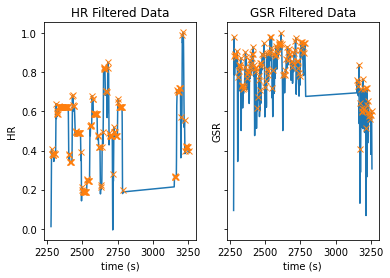

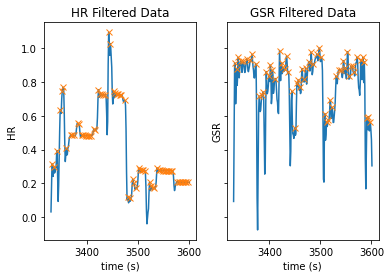

In [24]:
for i in range(unique_sections_num):
    grouped = df.groupby(df["Section_labels"])
    section = grouped.get_group(unique_sections[i])
    time = section['Time (s)'].to_numpy()
    HR_data = section["LPF_HR"].to_numpy()
    GSR_data = section["LPF_GSR"].to_numpy()
    #print('time', time, data)
    
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_title('HR Filtered Data')
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("HR")
    ax1.plot(time, HR_data)
    ax2.set_title('GSR Filtered Data')
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("GSR")
    ax2.plot(time, GSR_data)
    
    curr_peaks_ind, _ = find_peaks(HR_data)
    curr_peaks = HR_data[curr_peaks_ind]
    HR_max_peak = max(curr_peaks)
    HR_min_peak = min(curr_peaks)

    ax1.plot(time[curr_peaks_ind],curr_peaks, "x")
    
    HR_peaks.append(curr_peaks)
    HR_num_peaks.append(len(curr_peaks))
    HR_max_peaks.append(HR_max_peak)
    HR_min_peaks.append(HR_min_peak)
    
    HR_ave = np.mean(HR_data)
    HR_average.append(HR_ave)
    
    curr_peaks_ind, _ = find_peaks(GSR_data)
    curr_peaks = GSR_data[curr_peaks_ind]
    GSR_max_peak = max(curr_peaks)
    GSR_min_peak = min(curr_peaks)

    ax2.plot(time[curr_peaks_ind],curr_peaks, "x")
    
    GSR_peaks.append(curr_peaks)
    GSR_num_peaks.append(len(curr_peaks))
    GSR_max_peaks.append(GSR_max_peak)
    GSR_min_peaks.append(GSR_min_peak)
    
    GSR_ave = np.mean(GSR_data)
    GSR_average.append(GSR_ave)
    
    print(i, HR_max_peak, HR_min_peak, GSR_max_peak, GSR_min_peak, HR_ave, GSR_ave, labels[i])

In [25]:
stress_df = pd.DataFrame()
stress_df['HR_Max'] = pd.Series(HR_max_peaks)
stress_df['GSR_Max'] = pd.Series(GSR_max_peaks)
stress_df['HR_Min'] = pd.Series(HR_min_peaks)
stress_df['GSR_Min'] = pd.Series(GSR_min_peaks)
stress_df['HR_Ave'] = pd.Series(HR_average)
stress_df['GSR_Ave'] = pd.Series(GSR_average)
stress_df['Stress'] = pd.Series(labels)
stress_df

,HR_Max,GSR_Max,HR_Min,GSR_Min,HR_Ave,GSR_Ave,Stress
0,1.004099,1.037952,1.176733e-02,0.395537,0.426117,0.637964,2
1,0.993632,1.008564,2.128317e-02,0.166987,0.294892,0.456951,6
2,1.033479,1.005645,1.078768e-02,0.334760,0.354638,0.569663,4
3,1.025888,1.013269,4.621794e-03,0.313136,0.281455,0.623696,7
4,0.975993,1.057631,4.280954e-02,0.028560,0.325188,0.538868,6
5,1.050229,1.009443,2.614200e-03,0.009365,0.382477,0.420813,4
6,1.065875,1.005687,8.228688e-03,0.538039,0.397249,0.763593,4
7,0.962662,1.000463,1.444708e-01,0.013888,0.424833,0.573451,4
8,1.015751,1.000013,4.341160e-02,0.045566,0.495938,0.531116,5
9,0.985214,0.997141,3.907413e-03,0.109595,0.438370,0.484688,4


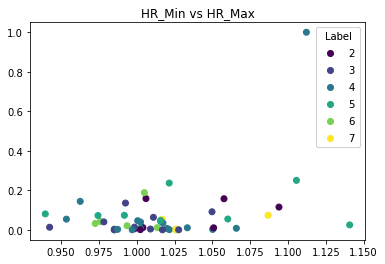

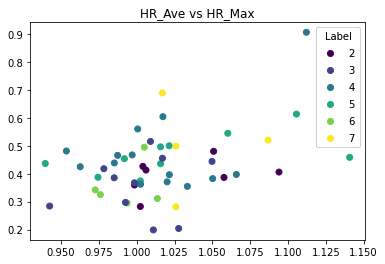

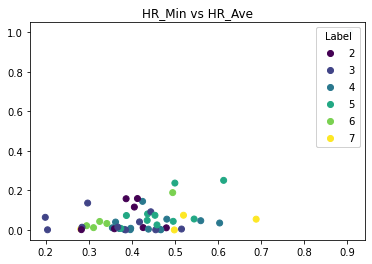

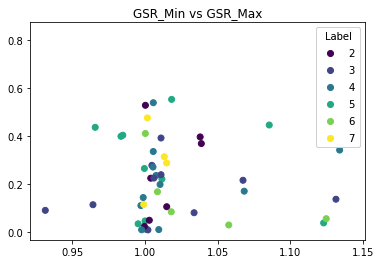

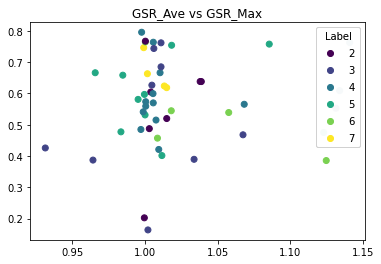

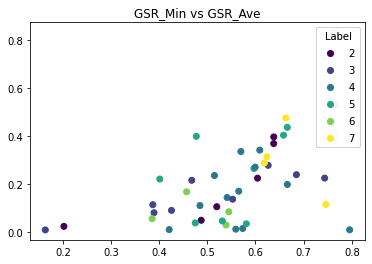

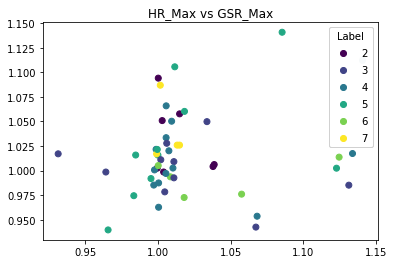

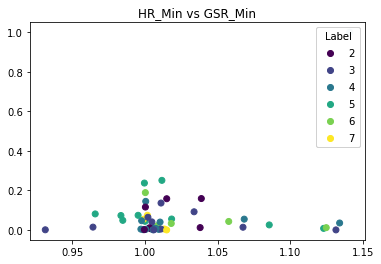

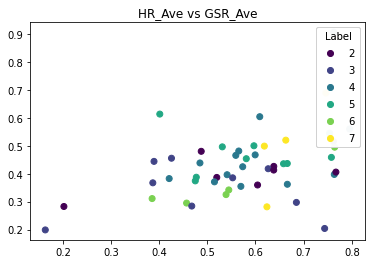

In [26]:
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[0]],stress_df[stress_df.columns[2]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[0]],stress_df[stress_df.columns[4]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Ave vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[4]],stress_df[stress_df.columns[2]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[3]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[5]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("GSR_Ave vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[5]],stress_df[stress_df.columns[3]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[0]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Max vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[1]],stress_df[stress_df.columns[2]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Min vs GSR_Min")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df[stress_df.columns[5]],stress_df[stress_df.columns[4]], c=stress_df[stress_df.columns[6]], cmap="viridis")
plt.title("HR_Ave vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

# Logistic Regression

In [27]:
X = stress_df.loc[:, ['HR_Max', 'GSR_Max', 'HR_Min', 'GSR_Min', 'HR_Ave', 'GSR_Ave']]
y = stress_df.loc[:, 'Stress']

In [28]:
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [29]:
# Save the trained model
# saved_model_name = "log_model_all.sav"
# saved_model = pickle.dump(clf, open(saved_model_name, "wb"))

# TESTING DATA

In [30]:
# TESTING DATA
df_test["Section_labels"] = df_test["Section"] + df_test["Stressed"].astype(str)
unique_sections_test = df_test["Section_labels"].unique()
unique_sections_num_test = df_test["Section_labels"].nunique()
print(unique_sections_test)

labels_test = []
for name in unique_sections_test:
    curr_label = df_test.loc[df_test["Section_labels"] == name, 'Stressed'].unique()[0]
    labels_test.append(curr_label)
    
print(labels_test)

['lab_wed_4_04' 'lab_wed_4_05' 'lab_wed_4_14' 'lab_wed_4_15'
 'lab_wed_4_13' 'lab_wed_4_22' 'lab_wed_4_23' 'lab_mon_55' 'lab_mon_53'
 'lab_mon_52' 'lab_mon_54' 'lab_mon_5_13' 'lab_mon_5_11' 'lab_mon_5_14'
 'lab_mon_5_16' 'lab_mon_5_17']
[4, 5, 4, 5, 3, 2, 3, 5, 3, 2, 4, 3, 1, 4, 6, 7]


In [31]:
# Moving average filter
df_test = df_test.groupby(df_test["Section_labels"]).apply(moving_ave_filter)

# Min-max normalisation
df_test = df_test.groupby(df_test["Section_labels"]).apply(min_max_normalisation)   

# Low pass filter
df_test = df_test.groupby(df_test["Section_labels"]).apply(low_pass)   

In [32]:
# Finding max and average test values
GSR_peaks_test = []
GSR_max_peaks_test = []
GSR_min_peaks_test = []
GSR_num_peaks_test = []
GSR_average_test = []

HR_peaks_test = []
HR_max_peaks_test = []
HR_min_peaks_test = []
HR_num_peaks_test = []
HR_average_test = []

In [33]:
for i in range(unique_sections_num_test):
    grouped = df_test.groupby(df_test["Section_labels"])
    section = grouped.get_group(unique_sections_test[i])
    time = section['Time (s)'].to_numpy()
    HR_data = section["LPF_HR"].to_numpy()
    GSR_data = section["LPF_GSR"].to_numpy()
    #print('time', time, data)
       
    curr_peaks_ind, _ = find_peaks(HR_data)
    curr_peaks = HR_data[curr_peaks_ind]
    HR_max_peak_test = max(curr_peaks)
    HR_min_peak_test = min(curr_peaks)
    
    HR_peaks_test.append(curr_peaks)
    HR_num_peaks_test.append(len(curr_peaks))
    HR_max_peaks_test.append(HR_max_peak_test)
    HR_min_peaks_test.append(HR_min_peak_test)
    
    HR_ave_test = np.mean(HR_data)
    HR_average_test.append(HR_ave_test)
    
    curr_peaks_ind, _ = find_peaks(GSR_data)
    curr_peaks = GSR_data[curr_peaks_ind]
    GSR_max_peak_test = max(curr_peaks)
    GSR_min_peak_test = min(curr_peaks)
    
    GSR_peaks_test.append(curr_peaks)
    GSR_num_peaks_test.append(len(curr_peaks))
    GSR_max_peaks_test.append(GSR_max_peak)
    GSR_min_peaks_test.append(GSR_min_peak)
    
    GSR_ave_test = np.mean(GSR_data)
    GSR_average_test.append(GSR_ave_test)
    
    print(i, HR_max_peak_test, GSR_max_peak_test, HR_min_peak_test, GSR_min_peak_test, HR_ave_test, GSR_ave_test, labels_test[i])

0 0.9626621814305277 1.000462527835053 0.1444708360592353 0.013888443596215156 0.4248333970079932 0.573450690157332 4
1 1.0157511406816233 1.0000134807526317 0.043411602783372305 0.04556626062962404 0.495938061291571 0.5311156688840292 5
2 0.9852144120257501 0.997140776833617 0.003907412633784324 0.10959536344130956 0.4383699600204888 0.4846882543686815 4
3 0.9395824352384428 0.9656772310508217 0.08093987798169977 0.43558402757441966 0.4364178133631465 0.6660259772544581 5
4 0.978300164268239 1.0047068038469538 0.04056745525379608 0.27715788015389586 0.41771618587892845 0.6263524489033423 3
5 0.9985339537646615 1.0039196307938223 0.005916626766352013 0.2236618860888836 0.35952377326676227 0.6043054834132154 2
6 1.0497995577555381 1.0337687589572935 0.09178629178140797 0.07970496432359456 0.4439583378113875 0.3893262359020971 3
7 1.0586265376583528 1.0007390631587998 0.0944351936575484 0.018308724675849524 0.42777975780800687 0.6468304272472387 5
8 1.0391102474341574 0.9931535959902971 

In [34]:
stress_df_test = pd.DataFrame()
stress_df_test['HR_Max'] = pd.Series(HR_max_peaks_test)
stress_df_test['GSR_Max'] = pd.Series(GSR_max_peaks_test)
stress_df_test['HR_Min'] = pd.Series(HR_min_peaks_test)
stress_df_test['GSR_Min'] = pd.Series(GSR_min_peaks_test)
stress_df_test['HR_Ave'] = pd.Series(HR_average_test)
stress_df_test['GSR_Ave'] = pd.Series(GSR_average_test)
stress_df_test['Stress'] = pd.Series(labels_test)
stress_df_test

,HR_Max,GSR_Max,HR_Min,GSR_Min,HR_Ave,GSR_Ave,Stress
0,0.962662,1.000244,0.144471,0.527358,0.424833,0.573451,4
1,1.015751,1.000244,0.043412,0.527358,0.495938,0.531116,5
2,0.985214,1.000244,0.003907,0.527358,0.438370,0.484688,4
3,0.939582,1.000244,0.080940,0.527358,0.436418,0.666026,5
4,0.978300,1.000244,0.040567,0.527358,0.417716,0.626352,3
5,0.998534,1.000244,0.005917,0.527358,0.359524,0.604305,2
6,1.049800,1.000244,0.091786,0.527358,0.443958,0.389326,3
7,1.058627,1.000244,0.094435,0.527358,0.427780,0.646830,5
8,1.039110,1.000244,0.091302,0.527358,0.466248,0.473140,3
9,1.021273,1.000244,0.030696,0.527358,0.519374,0.136048,2


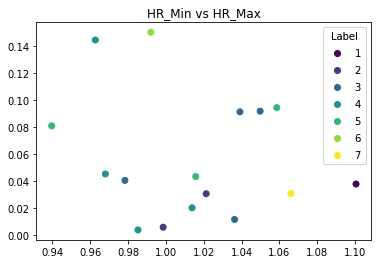

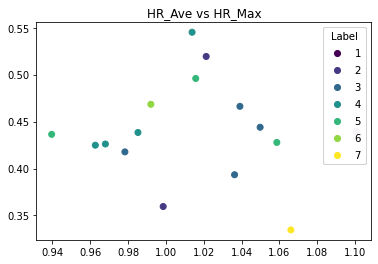

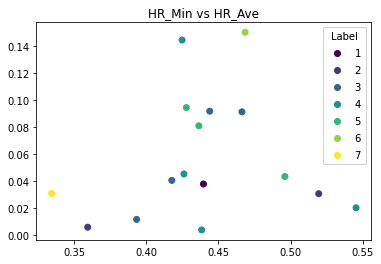

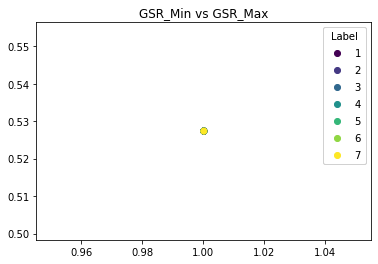

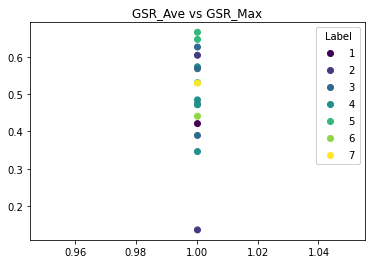

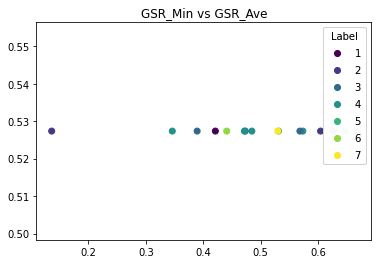

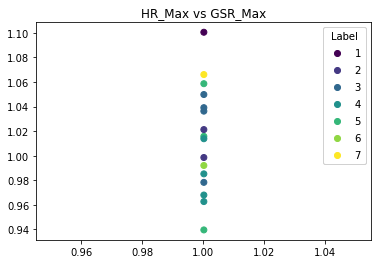

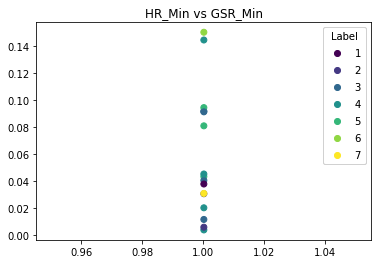

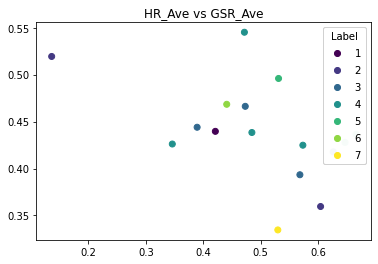

In [35]:
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[0]],stress_df_test[stress_df_test.columns[2]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[0]],stress_df_test[stress_df_test.columns[4]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Ave vs HR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[4]],stress_df_test[stress_df_test.columns[2]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Min vs HR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[3]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[5]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("GSR_Ave vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[5]],stress_df_test[stress_df_test.columns[3]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("GSR_Min vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[0]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Max vs GSR_Max")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[1]],stress_df_test[stress_df_test.columns[2]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Min vs GSR_Min")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()
figure, ax1 = plt.subplots()
scatter = ax1.scatter(stress_df_test[stress_df_test.columns[5]],stress_df_test[stress_df_test.columns[4]], c=stress_df_test[stress_df_test.columns[6]], cmap="viridis")
plt.title("HR_Ave vs GSR_Ave")
legend1 = ax1.legend(*scatter.legend_elements(), loc="upper right", title="Label")
ax1.add_artist(legend1)
plt.show()

In [36]:
#Testing model

# saved_model_name = "log_model_all.sav"
# clf = pickle.load(open(saved_model_name, 'rb'))

tp = 0
fp = 0
tn = 0
fn = 0

predicted_labels = []
actual_labels = []

for i in range(len(stress_df_test)):
    predicted_label = clf.predict([stress_df_test.iloc[i, 0:6]])[0]
    print(i)
    actual_label = stress_df_test.iloc[i, 6]

    if predicted_label >= 5:
        print("Predicted: Stressed", predicted_label)
        if actual_label >= 5:
            print("Actual: Stressed", actual_label)
            tp += 1
        else:
            print("Actual: Not Stressed", actual_label)  
            fp += 1
            
    else:
        print("Predicted: Not Stressed", predicted_label)
        if actual_label >= 5:
            print("Actual: Stressed", actual_label)
            fn += 1 
        else:
            print("Actual: Not Stressed", actual_label)
            tn += 1
    
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)
    
print("\nTotal:", tp+tn+fp+fn, "\n")

acc = (tp+tn)/(tp+tn+fp+fn)*100
sensitivity = tp/(tp+fn)*100 # true positive rate
specificity = tn/(tn+fp)*100# true negative rate
#precision = tp/(tp+fp)*100

print("TP: {}, TN = {}, FP: {}, FN: {}".format(tp, tn, fp, fn))
print("Accuracy: {}, Sensitivity: {}, Specificity: {}".format(acc, sensitivity, specificity))

0
Predicted: Not Stressed 4
Actual: Not Stressed 4
1
Predicted: Not Stressed 4
Actual: Stressed 5
2
Predicted: Not Stressed 4
Actual: Not Stressed 4
3
Predicted: Not Stressed 4
Actual: Stressed 5
4
Predicted: Not Stressed 4
Actual: Not Stressed 3
5
Predicted: Not Stressed 4
Actual: Not Stressed 2
6
Predicted: Not Stressed 4
Actual: Not Stressed 3
7
Predicted: Not Stressed 4
Actual: Stressed 5
8
Predicted: Not Stressed 4
Actual: Not Stressed 3
9
Predicted: Not Stressed 4
Actual: Not Stressed 2
10
Predicted: Not Stressed 4
Actual: Not Stressed 4
11
Predicted: Not Stressed 4
Actual: Not Stressed 3
12
Predicted: Not Stressed 4
Actual: Not Stressed 1
13
Predicted: Not Stressed 4
Actual: Not Stressed 4
14
Predicted: Not Stressed 4
Actual: Stressed 6
15
Predicted: Not Stressed 4
Actual: Stressed 7

Total: 16 

TP: 0, TN = 11, FP: 0, FN: 5
Accuracy: 68.75, Sensitivity: 0.0, Specificity: 100.0


In [37]:
#confusion matrix
cm = metrics.confusion_matrix(actual_labels, predicted_labels)
print(cm)
print(predicted_labels)

[[0 0 0 1 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


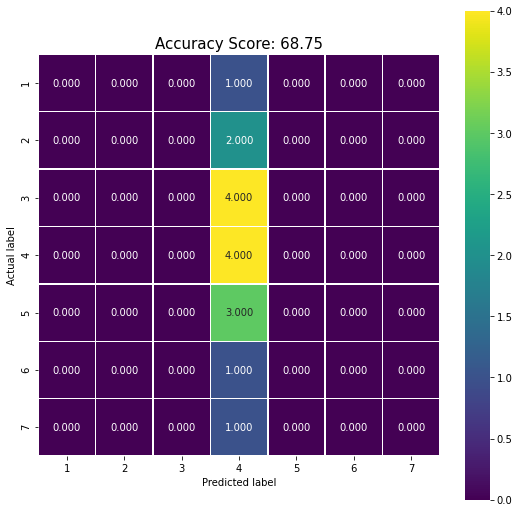

In [38]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis', xticklabels=[1,2,3,4,5,6,7], yticklabels=[1,2,3,4,5,6,7]);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);